In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import math
%matplotlib inline
import warnings
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings('ignore')
from matplotlib import gridspec

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)

def mdtest(fname):
    with open(fname) as f:
        start = end = ""
        data = json.load(f)
        for line in data['stdout_lines']:
            if "started" in line: start = line.split()[4]
            if "finished" in line: end = line.split()[4]
        result = to_seconds(end) - to_seconds(start)
        if result < 0: return 0
        return result
    
def parse(expdir):
    df = pd.DataFrame(columns=['job', 'nfile', 'rtime', 'run'])
    for run in [0, 1, 2]:
        for s in ["stream", "nostream"]:
            rundir = expdir + '-run' + str(run) + '/100000/summary-'
            with open(rundir + s + '.txt') as f:
                d = pd.read_csv(f, names=['job', 'time', 'delta'])
                d['rtime'] = d['delta'].apply(to_seconds)
                d['nfile'] = np.full(len(d), '100000')
                del d['time'], d['delta']
                d['job'] = d['job'] + '-' + s
                d['run'] = run
                df = df.append(d, ignore_index=True)

            # parse the RPCs execution times
            df.loc[len(df)] = ["RPCs-" + s] + [float('100000')] + [mdtest(rundir + 'rpcs-' + s + '.txt')] + [run]
        del df['nfile']
    return df.pivot(index='run', values='rtime', columns='job')
    
def transfertime():
    with open("../results-all/dummy100k.txt") as f:
        for line in f:
            y = line
    return float(y)

def relabel(df):
    for j in ['RPCs', 'create', 'save', 'persist', 'v.apply', 'apply']:
        for s in ["stream", "nostream"]:
            dfs = [j + '-' + s + '-run0']
            df[j + '-' + s] = df[dfs].mean(axis=1)
    return df

# calculate the phase execution times
def calculate(df):
    df['RPCs'] =              df['RPCs-nostream']
    df['stream'] =            df['RPCs-stream'] - df['RPCs-nostream']
    df['create'] =            df['create-nostream']
    df['local persist'] =     df['save-nostream'] - df['create']
    df['global persist'] =    df['persist-nostream']
    df['volatile apply'] =    df['v.apply-nostream'] + transfertime()
    df['nonvolatile apply'] = df['apply-nostream'] - df['create']
    dur = pd.DataFrame(); con = pd.DataFrame()
    dur['stream'] = df['stream']
    dur['local\npersist'] = df['local persist']
    dur['global\npersist'] = df['global persist']
    con['append client\njournal (baseline)'] = df['create'] 
    con['volatile apply'] = df['volatile apply']
    con['nonvolatile apply'] = df['nonvolatile apply']
    con['RPCs'] = df['RPCs']
    return dur, con

def layer(layers, label, values):
    means = [v.mean() for v in values]
    layers[0][label] = [np.sum(means)]
    layers[1][label] = [np.sum(means[:2])]
    layers[2][label] = [np.sum(means[:1])]
    return layers

11K op/sec
       POSIX   DeltaFS  RAMDisk     HDFS
0  20.295997  1.210859      1.0  2.29455
     append client\njournal (baseline)  volatile apply  nonvolatile apply  \
run                                                                         
0.0                           0.994724        0.935186          78.964252   
1.0                           1.010770        0.934496          77.503400   
2.0                           0.994506        0.933867          77.419935   

          RPCs  
run             
0.0  17.863382  
1.0  17.863382  
2.0  18.081228  
       stream  local\npersist  global\npersist
run                                           
0.0  2.287384        0.197642         0.359260
1.0  2.723077        0.213739         0.357871
2.0  2.069538        0.221196         0.362970


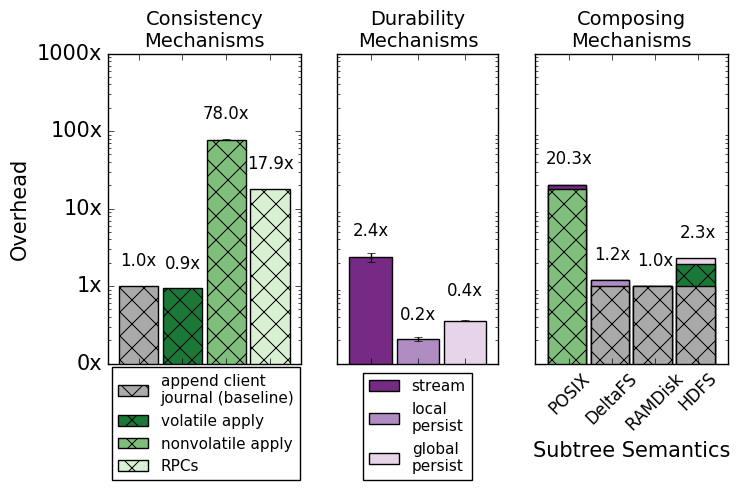

In [3]:
font = {'size'   : 15}; matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[1.2, 1, 1.2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# mechanisms normalized to 'create'
df = parse('../results-cloudlab-nostream')
durability, consistency = calculate(df)
c = consistency/consistency['append client\njournal (baseline)'].mean()
d = durability/consistency['append client\njournal (baseline)'].mean()
(c.mean()).plot.bar(ax=ax0, yerr=c.std(), width=0.9, label='', color=['#aaaaaa', '#1b7837',  '#7fbf7b', '#d9f0d3'])
(d.mean()).plot.bar(ax=ax1, yerr=d.std(), width=0.9, label='', color=['#762a83', '#af8dc3', '#e7d4e8'])

# compositions are done in layers
n = ['POSIX', 'DeltaFS', 'RAMDisk', 'HDFS']
l = [pd.DataFrame(columns=n), pd.DataFrame(columns=n), pd.DataFrame(columns=n)]
l = layer(l, 'POSIX',   [c['RPCs'], d['stream']])
l = layer(l, 'DeltaFS', [c['append client\njournal (baseline)'], d['local\npersist']])
l = layer(l, 'RAMDisk', [c['append client\njournal (baseline)']])
l = layer(l, 'HDFS',    [c['append client\njournal (baseline)'], c['volatile apply'], d['global\npersist']])
x = [0.5, 1.5, 2.5, 3.5]
ax2.bar(x, l[0].as_matrix()[0], width=0.9, color=['black', 'black', 'black', '#e7d4e8'])
ax2.bar(x, l[1].as_matrix()[0], width=0.9, color=['#762a83', '#af8dc3',  'black', '#1b7837'])
ax2.bar(x, l[2].as_matrix()[0], width=0.9, hatch='x', color=['#7fbf7b', '#aaaaaa',  '#aaaaaa', '#aaaaaa'])

# set hatches to distinguish consistency mechs
for bar, label in zip(ax0.patches, c.columns):
    bar.set_hatch('x')
    bar.set_label(label)
ax0.legend(fontsize=11, loc='lower left', bbox_to_anchor=(-0.02, -0.4))    
for bar, label in zip(ax1.patches, d.columns):
    bar.set_label(label)    
ax1.legend(fontsize=11, loc='lower left', bbox_to_anchor=(0.11, -0.4))
for bar, h in zip(ax2.patches, 'xxx    x'):
    bar.set_hatch(h)
labels = [""]
for column in l[0].columns:
    labels.append(column)
ax2.set_xticklabels(labels, rotation=45, fontsize=12)

# format
for axis in [ax0, ax1, ax2]:
    axis.set_yscale('log')    
    axis.set_ylim([10**-1,10**3])
ax0.set_title("Consistency\nMechanisms", fontsize=14)
ax0.set_ylabel("Overhead")
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))
ax0.set_xticklabels([])    
ax1.set_title("Durability\nMechanisms", fontsize=14)
ax1.set_yticks([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_xlim(0.2, 4.7)
ax2.set_title("Composing\nMechanisms", fontsize=14)
ax2.set_xlabel("Subtree Semantics", fontsize=15)

# annotate
bops = str(int(round((100000/consistency['append client\njournal (baseline)'].mean())/1024))) + "K op/sec"
print bops
def annotate_overhead(ax, df, args, i=0, inc=1):
    args = {'fontsize': 12, 'horizontalalignment': 'center'}
    for c in df.columns:
        top = round(df[c].mean(), 1)
        ax.annotate(str(top) + "x\n", xy=(i, top), xytext=(i, top), **args)
        i += inc
args = {'fontsize': 12, 'horizontalalignment': 'center'}
annotate_overhead(ax0, c, args, i=0)
annotate_overhead(ax1, d, args, i=0)
annotate_overhead(ax2, l[0], args, i=1)
fig.savefig('../../../paper/graphs/composable-mechanisms.png', dpi=400, bbox_inches='tight')
print l[0]
print c
print d